In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Import and load data


In [3]:
# Importing the dataset
data = pd.read_csv('datasets/full_data_predict.csv')

In [4]:
data.head()

,timestamp,row,col,WVB,B12B,B14B,IRB,I4B,B10B,B11B,...,PEV,lgb_aws_value,rf_aws_value,xgb_aws_value,nn_aws_value,ensemble_lgb,lgbm_aws_value,ensemble_ada,ensemble_rf,ensemble_nn
0,2020-10-31 17:00:00,0,0,239.37927,258.85202,279.97256,280.07922,278.69775,256.80002,277.66720,...,0.000007,0.749971,0.797263,0.742249,-854.99410,1.073281,0.749971,0.500429,0.517235,2.136890
1,2020-10-31 17:00:00,0,1,239.37927,258.85202,279.97256,280.07922,278.69775,256.80002,277.66720,...,0.000007,0.749971,0.797263,0.742249,-854.99410,1.073281,0.749971,0.500429,0.517235,2.136890
2,2020-10-31 17:00:00,0,2,239.49336,258.95267,279.97256,280.15768,278.77010,256.80002,277.66720,...,0.000007,0.749971,0.779554,0.742249,-854.98140,1.073281,0.749971,0.500429,0.496778,2.134874
3,2020-10-31 17:00:00,0,3,239.49336,258.95267,280.21103,280.15768,278.62033,256.80002,277.74612,...,0.000004,0.683799,0.874855,0.832382,-353.06076,1.115583,0.683799,0.507724,0.591488,0.796297
4,2020-10-31 17:00:00,0,4,239.49336,258.95267,280.21103,280.15768,278.62033,256.80002,277.74612,...,0.000004,0.683799,0.874855,0.832382,-353.06076,1.115583,0.683799,0.507724,0.591488,0.796297


In [5]:
data_3h = data[(data['timestamp'] >= '2020-10-31 03:00:00') & (data['timestamp'] < '2020-10-31 04:00:00')]
data_6h = data[(data['timestamp'] >= '2020-10-31 06:00:00') & (data['timestamp'] < '2020-10-31 07:00:00')]
data_9h = data[(data['timestamp'] >= '2020-10-31 09:00:00') & (data['timestamp'] < '2020-10-31 10:00:00')]
data_12h = data[(data['timestamp'] >= '2020-10-31 12:00:00') & (data['timestamp'] < '2020-10-31 13:00:00')]

In [6]:
data_aws = pd.read_csv('datasets/meta_nn_final.csv')

In [7]:
data_aws_3h = data_aws[(data_aws['timestamp'] >= '2020-10-31 03:00:00') & (data_aws['timestamp'] < '2020-10-31 04:00:00')]
data_aws_6h = data_aws[(data_aws['timestamp'] >= '2020-10-31 06:00:00') & (data_aws['timestamp'] < '2020-10-31 07:00:00')]
data_aws_9h = data_aws[(data_aws['timestamp'] >= '2020-10-31 09:00:00') & (data_aws['timestamp'] < '2020-10-31 10:00:00')]
data_aws_12h = data_aws[(data_aws['timestamp'] >= '2020-10-31 12:00:00') & (data_aws['timestamp'] < '2020-10-31 13:00:00')]

In [ ]:
# Ghép cột aws_value từ data_aws sang data theo 3 cột timestamp, row và col
data_merged_3h = pd.merge(data_3h, data_aws_3h[['timestamp', 'row', 'col', 'aws_value']], on=['timestamp', 'row', 'col'], how='left')
# Lọc các dòng không có giá trị thiếu ở cột aws_value
data_merged_3h = data_merged_3h.dropna(subset=['aws_value'])

data_merged_6h = pd.merge(data_6h, data_aws_6h[['timestamp', 'row', 'col', 'aws_value']], on=['timestamp', 'row', 'col'], how='left')
data_merged_6h = data_merged_6h.dropna(subset=['aws_value'])

data_merged_9h = pd.merge(data_9h, data_aws_9h[['timestamp', 'row', 'col', 'aws_value']], on=['timestamp', 'row', 'col'], how='left')
data_merged_9h = data_merged_9h.dropna(subset=['aws_value'])

data_merged_12h = pd.merge(data_12h, data_aws_12h[['timestamp', 'row', 'col', 'aws_value']], on=['timestamp', 'row', 'col'], how='left')
data_merged_12h = data_merged_12h.dropna(subset=['aws_value'])

In [25]:
def plot_results(dataset, title):
    # Plot the results of aws_value and ensemble_aws_value
    plt.figure(figsize=(12, 4))

    # Plot aws_value
    plt.plot(dataset.reset_index()['aws_value'], label='Ground Truth')

    # Plot ensemble_aws_value
    plt.plot(dataset.reset_index()['ensemble_nn'], label='Predicted')

    # Add title and labels
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Value (mm/h)')
    plt.legend()

    # Show the plot
    plt.show()

In [10]:
import matplotlib.patches as patches

In [24]:
def plot_maps(datasets, titles):
    # Initialize an empty list to store vmax values
    vmax_values = []

    for dataset in datasets:
        # Initialize an empty image
        image = np.zeros((90, 250))

        # Fill the image with data values
        for index, row in dataset.iterrows():
            r = row['row']
            c = row['col']
            if 'aws_value' in dataset.columns:
                value = row['aws_value']
            else:
                value = row['ensemble_nn']
            image[r, c] = value

        # Crop the image to only include columns 50 to 200
        cropped_image = image[:, 50:201]

        # Calculate vmax for the current dataset
        vmax = np.max(cropped_image)
        vmax_values.append(vmax)

    # Get the maximum vmax value from both datasets
    max_vmax = max(vmax_values)

    # Plot both datasets with the same vmax
    for i, dataset in enumerate(datasets):
        # Initialize an empty image
        image = np.zeros((90, 250))

        # Fill the image with data values
        for index, row in dataset.iterrows():
            r = row['row']
            c = row['col']
            if 'aws_value' in dataset.columns:
                value = row['aws_value']
            else:
                value = row['ensemble_nn']
            image[r, c] = value

        # Crop the image to only include columns 50 to 200
        cropped_image = image[:, 50:201]

        # Create a colormap with white for zero values
        cmap = plt.cm.viridis
        cmap.set_under('white')

        # Plot the cropped image
        plt.figure(figsize=(8, 4))
        plt.imshow(cropped_image, cmap=cmap, aspect='auto', vmin=0.01, vmax=max_vmax)
        plt.colorbar(label='mm/h')
        plt.xlabel('Column')
        plt.ylabel('Row')
        plt.title(titles[i])

        # Set x-axis ticks and labels starting from 50
        plt.xticks(ticks=np.arange(0, cropped_image.shape[1], 10), labels=np.arange(50, 201, 10))

        # Define bounding boxes
        boxes = [
            {"xy": (95 - 50, 0), "width": 116 - 95, "height": 19 - 0, "edgecolor": 'r', "label": 'Hoà Bình'},
            {"xy": (84 - 50, 10), "width": 127 - 84, "height": 45 - 10, "edgecolor": 'g', "label": 'Thanh Hoá'},
            {"xy": (71 - 50, 27), "width": 119 - 71, "height": 63 - 27, "edgecolor": 'b', "label": 'Nghệ An'},
            {"xy": (102 - 50, 62), "width": 137 - 102, "height": 80 - 62, "edgecolor": 'y', "label": 'Hà Tĩnh'}
        ]

        # Add bounding boxes to the plot
        for box in boxes:
            rect = patches.Rectangle(**box, linewidth=2, facecolor='none')
            plt.gca().add_patch(rect)

        # Add legend
        handles = [patches.Patch(color=box["edgecolor"], label=box["label"]) for box in boxes]
        plt.legend(handles=handles, loc='upper right')

        plt.show()


In [ ]:
def calculate_region_averages(data_merged):
    # Define the regions with their respective pixel ranges
    regions = {
    'Hoà Bình': {'row_range': (0, 19), 'col_range': (95, 116)},
    'Thanh Hoá': {'row_range': (10, 45), 'col_range': (84, 127)},
    'Nghệ An': {'row_range': (27, 63), 'col_range': (71, 119)},
    'Hà Tĩnh': {'row_range': (62, 80), 'col_range': (102, 137)}
    }

    region_averages = {}
    for region, ranges in regions.items():
        row_min, row_max = ranges['row_range']
        col_min, col_max = ranges['col_range']
        
        # Filter the data for the specified region
        region_data = data_merged[(data_merged['row'] >= row_min) & (data_merged['row'] <= row_max) &
                                  (data_merged['col'] >= col_min) & (data_merged['col'] <= col_max)]

        # Calculate the mean values
        aws_value_mean = region_data['aws_value'].mean()
        ensemble_aws_value_mean = region_data['ensemble_nn'].mean()
        
        # Store the results
        region_averages[region] = {
            'aws_value_mean': aws_value_mean,
            'ensemble_aws_value_mean': ensemble_aws_value_mean
        }
    
    # Print the results
    for region, averages in region_averages.items():
        print(f"{region}:")
        print(f"{averages['aws_value_mean']:.4f} {averages['ensemble_aws_value_mean']:.4f}")

# 3h


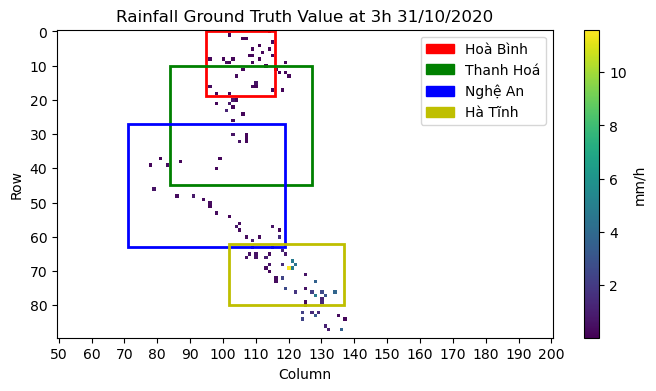

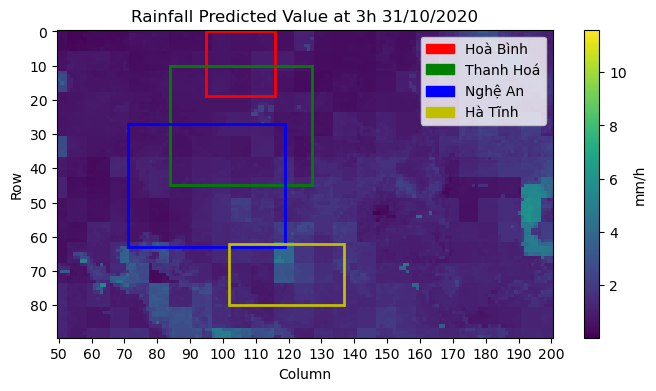

In [30]:
datasets_3h = [data_aws_3h, data_3h]
titles_3h = ['Rainfall Ground Truth Value at 3h 31/10/2020', 'Rainfall Predicted Value at 3h 31/10/2020']
plot_maps(datasets_3h, titles_3h)

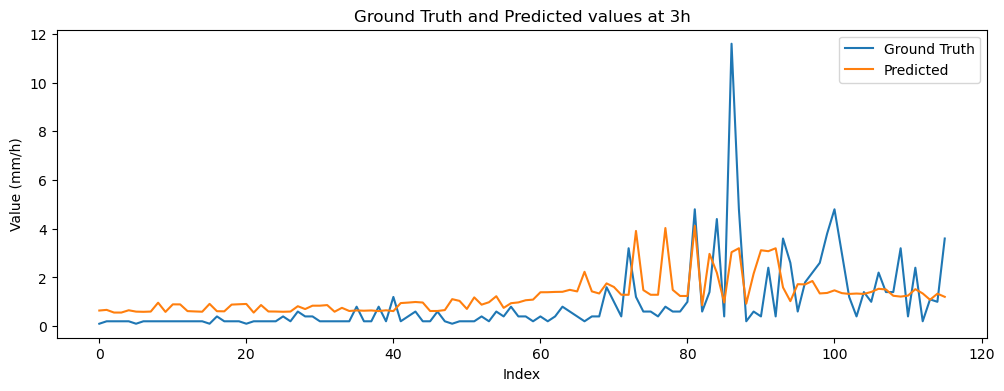

In [26]:
plot_results(data_merged_3h, 'Ground Truth and Predicted values at 3h')

In [31]:
calculate_region_averages(data_merged_3h)

3h:
Hoà Bình:
0.2267 0.7139
Thanh Hoá:
0.3323 0.7449
Nghệ An:
0.5300 1.1763
Hà Tĩnh:
2.0114 1.9203


# 6h


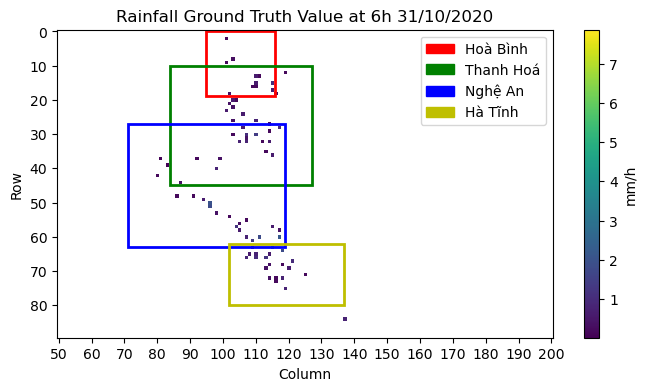

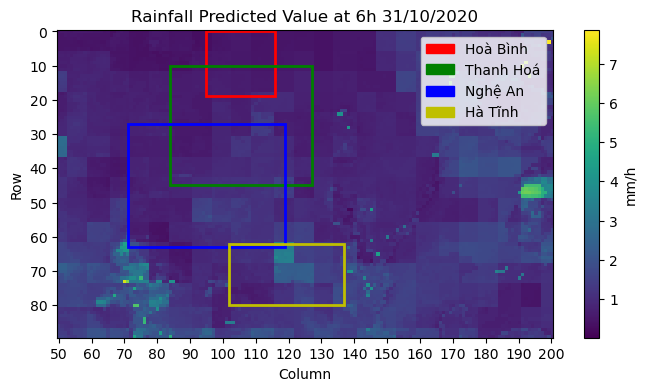

In [33]:
datasets_6h = [data_aws_6h, data_6h]
titles_6h = ['Rainfall Ground Truth Value at 6h 31/10/2020', 'Rainfall Predicted Value at 6h 31/10/2020']
plot_maps(datasets_6h, titles_6h)

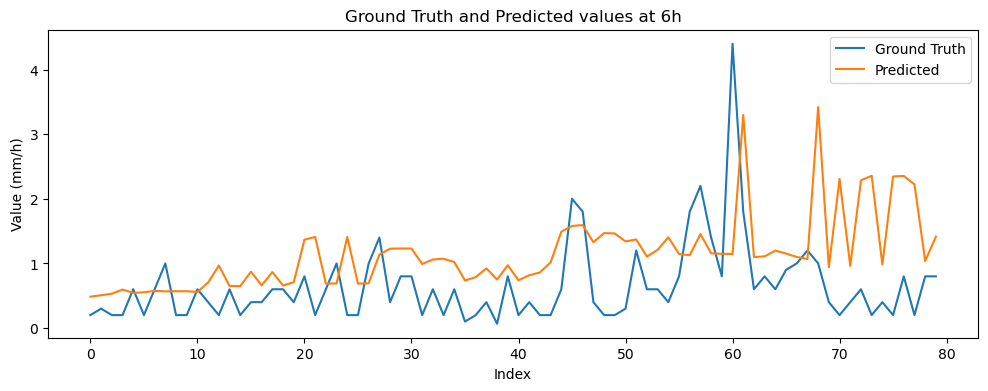

In [27]:
plot_results(data_merged_6h, 'Ground Truth and Predicted values at 6h')

In [34]:
calculate_region_averages(data_merged_6h)

3h:
Hoà Bình:
0.3917 0.5945
Thanh Hoá:
0.5056 0.8524
Nghệ An:
0.7617 1.1170
Hà Tĩnh:
0.8650 1.6768


# 9h


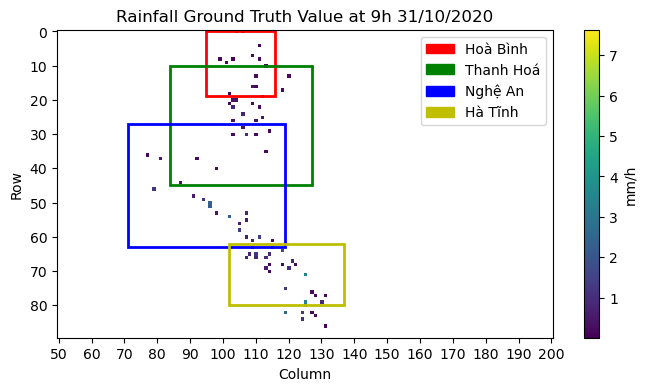

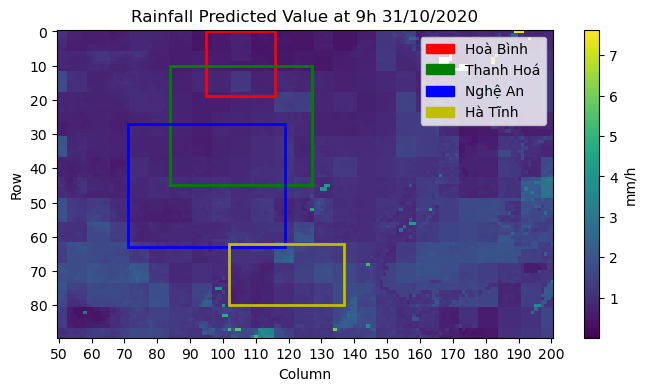

In [35]:
datasets_9h = [data_aws_9h, data_9h]
titles_9h = ['Rainfall Ground Truth Value at 9h 31/10/2020', 'Rainfall Predicted Value at 9h 31/10/2020']
plot_maps(datasets_9h, titles_9h)

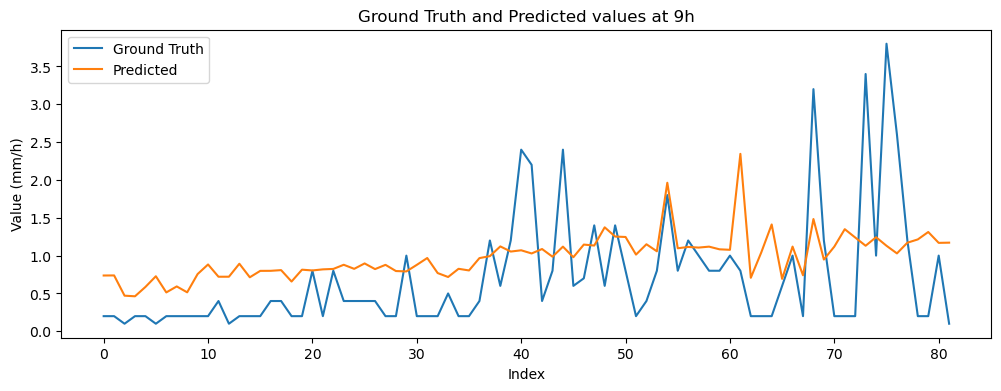

In [28]:
plot_results(data_merged_9h, 'Ground Truth and Predicted values at 9h')

In [36]:
calculate_region_averages(data_merged_9h)

3h:
Hoà Bình:
0.1929 0.6467
Thanh Hoá:
0.3296 0.8095
Nghệ An:
0.7786 1.0009
Hà Tĩnh:
1.0417 1.1861


# 12h


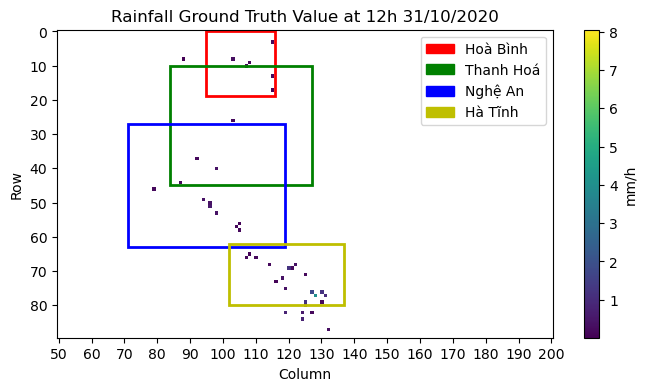

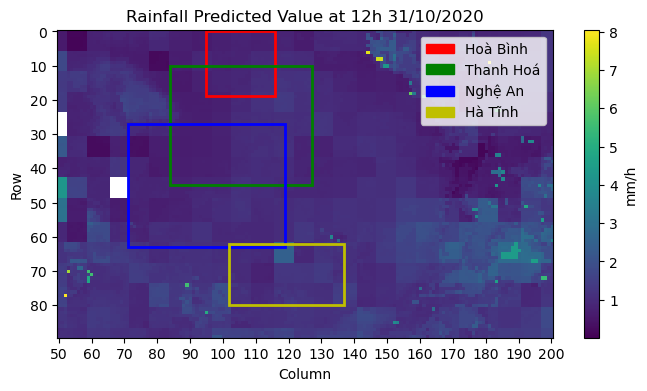

In [37]:
datasets_12h = [data_aws_12h, data_12h]
titles_12h = ['Rainfall Ground Truth Value at 12h 31/10/2020', 'Rainfall Predicted Value at 12h 31/10/2020']
plot_maps(datasets_12h, titles_12h)

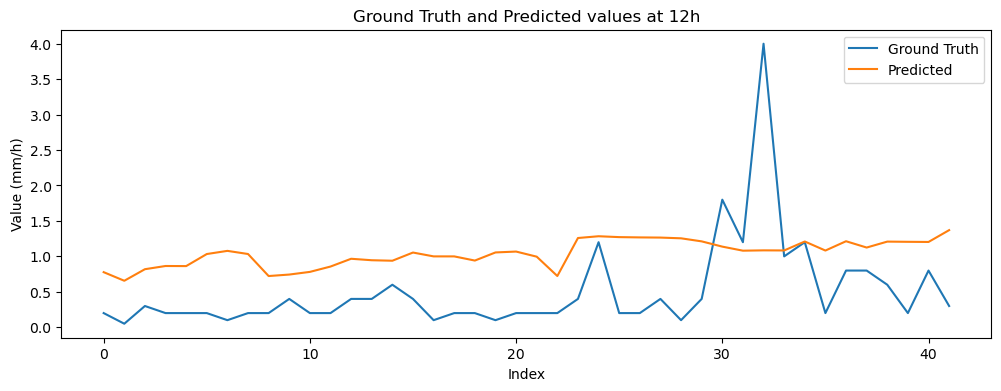

In [29]:
plot_results(data_merged_12h, 'Ground Truth and Predicted values at 12h')

In [38]:
calculate_region_averages(data_merged_12h)

3h:
Hoà Bình:
0.2000 0.9058
Thanh Hoá:
0.2143 0.8935
Nghệ An:
0.3000 0.9045
Hà Tĩnh:
0.7667 1.1416
